11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
235/235 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 0.2687 - val_loss: 0.1138
Epoch 2/2
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.1117 - val_loss: 0.1070
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


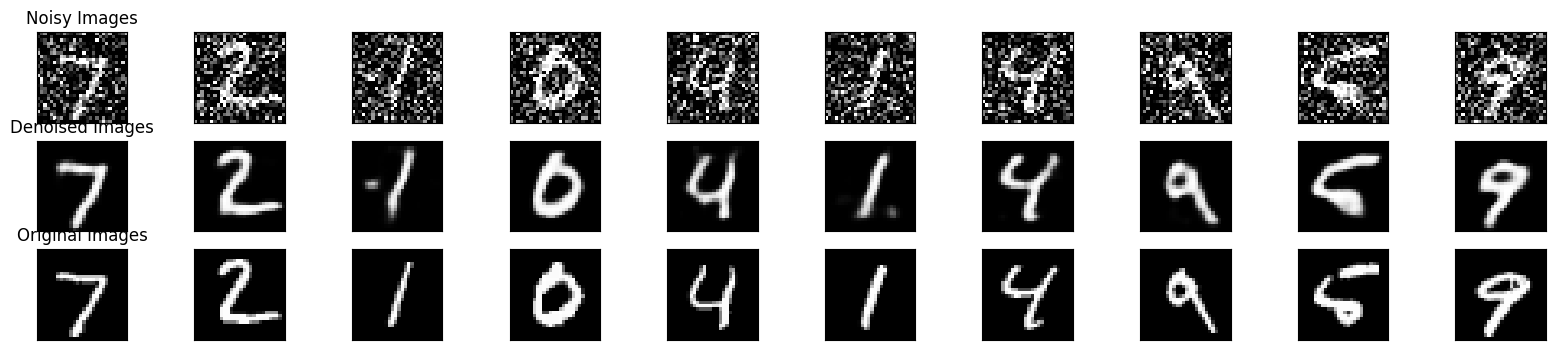

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize images to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add random noise to the images
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # Ensure pixel values stay between 0 and 1
    return noisy_images

# Add noise to the training and test data
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Reshape the data to add a channel dimension (for grayscale images, it will be 1)
x_train_noisy = x_train_noisy.reshape((-1, 28, 28, 1))
x_test_noisy = x_test_noisy.reshape((-1, 28, 28, 1))
x_train = x_train.reshape((-1, 28, 28, 1))
x_test = x_test.reshape((-1, 28, 28, 1))

# Define the Autoencoder model
def build_autoencoder():
    # Encoder
    input_img = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

# Build the autoencoder
autoencoder = build_autoencoder()

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=2,
    batch_size=256,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)

# Predict denoised images
denoised_images = autoencoder.predict(x_test_noisy)

# Visualize results
def visualize_denoising_results(noisy_images, denoised_images, clean_images, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Noisy image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title('Noisy Images')

        # Denoised image
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title('Denoised Images')

        # Original image
        ax = plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(clean_images[i].reshape(28, 28), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title('Original Images')
    plt.show()

# Display the results
visualize_denoising_results(x_test_noisy, denoised_images, x_test)
